In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

# Preprocessing

In [3]:
data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Kaggle/News-Category/dataset/News_Category_Dataset_v2.json', lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
# 2. Remove punctiation & convert to lowercase:
data['headline_processed'] = data.headline.str.replace('[{}]'.format(string.punctuation), '').str.lower()
data['short_description_processed'] = data.short_description.str.replace('[{}]'.format(string.punctuation), '').str.lower()

In [5]:
def category_cleaner(x):
    
    if x == 'THE WORLDPOST':
        return 'WORLDPOST'
    elif x == 'PARENTING':
        return 'PARENTS'
    elif x == 'ARTS' or x == 'CULTURE & ARTS':
        return 'ARTS & CULTURE'
    elif x == 'STYLE':
        return 'STYLE & BEAUTY'
    elif x == 'COLLEGE':
        return 'EDUCATION'
    elif x == 'TASTE':
        return 'FOOD & DRINK'
    else:
        return x
    
data['category'] = data.category.apply(category_cleaner)


le = LabelEncoder()
data_labels = le.fit_transform(data.category)
list(le.classes_)

['ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COMEDY',
 'CRIME',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE & BEAUTY',
 'TECH',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST']

In [6]:
data.authors.unique()

array(['Melissa Jeltsen', 'Andy McDonald', 'Ron Dicker', ...,
       'Courtney Garcia, Contributor\nI tell stories and drink wine.',
       'Mateo Gutierrez, Contributor\nArtist',
       'John Giacobbi, Contributor\nTales from the Interweb by The Web Sheriff'],
      dtype=object)

In [7]:
data['authors'] = data.authors.apply(lambda x: x.split(',')[0])
data['authors'] = data.authors.str.replace(' ', '', regex=False)
data.authors.unique()

array(['MelissaJeltsen', 'AndyMcDonald', 'RonDicker', ..., 'SarahCosta',
       'MateoGutierrez', 'JohnGiacobbi'], dtype=object)

In [8]:
data["category"].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'PARENTS',
       'ARTS & CULTURE', 'STYLE & BEAUTY', 'GREEN', 'FOOD & DRINK',
       'HEALTHY LIVING', 'WORLDPOST', 'GOOD NEWS', 'FIFTY', 'WELLNESS',
       'HOME & LIVING', 'DIVORCE', 'WEDDINGS', 'MONEY', 'ENVIRONMENT'],
      dtype=object)

In [9]:
top_categories = ["POLITICS", "HEALTHY LIVING", "ENTERTAINMENT", "PARENTS", "STYLE & BEAUTY", "TRAVEL", "WEIRD NEWS", "FOOD & DRINK", "BUSINESS", "ECONOMY", "DIVORCE", "WEDDINGS"]

In [10]:
# data=data.loc[data['category'].isin(top_categories)]
# # 

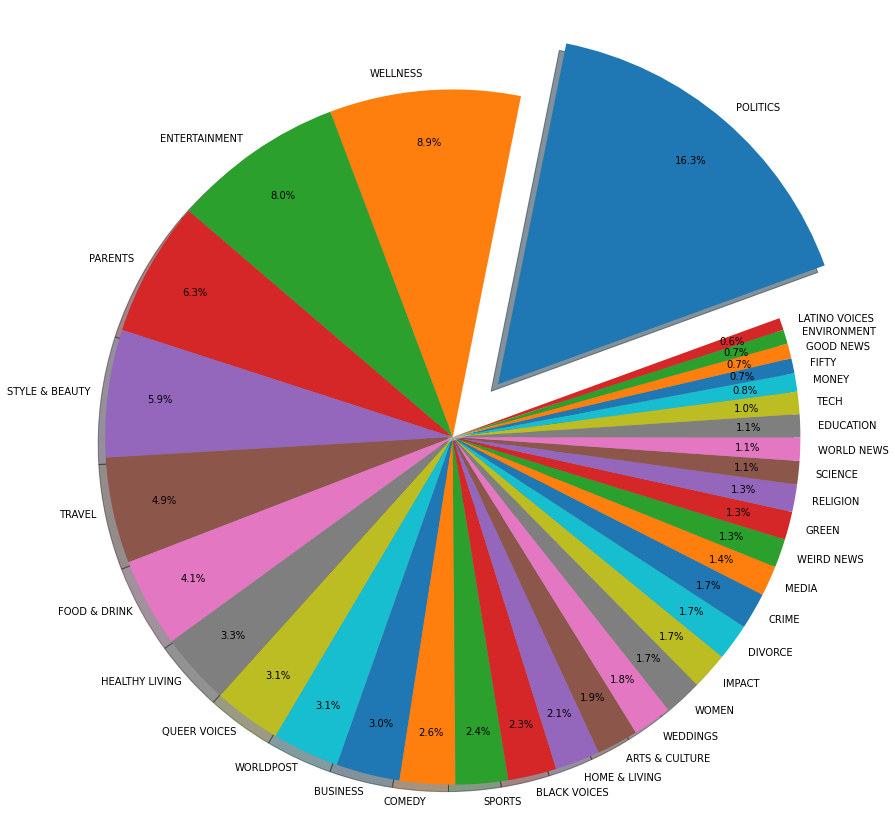

In [11]:
plt.figure(figsize=(15,15))
sizes = data.category.value_counts().values
labels = data.category.value_counts().index
plt.pie(sizes, labels=labels, autopct='%.1f%%',
        shadow=True, pctdistance=0.85, labeldistance=1.05, startangle=20, 
        explode = [0 if i > 0 else 0.2 for i in range(len(sizes))])
plt.axis('equal')
plt.show()

In [12]:
data.head()

,category,headline,authors,link,short_description,date,headline_processed,short_description_processed
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,MelissaJeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,there were 2 mass shootings in texas last week...,she left her husband he killed their children ...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,AndyMcDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,will smith joins diplo and nicky jam for the 2...,of course it has a song
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,RonDicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries for the first time at age 57,the actor and his longtime girlfriend anna ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,RonDicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,jim carrey blasts castrato adam schiff and dem...,the actor gives dems an asskicking for not fig...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,RonDicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies uses donald trump poop bags...,the dietland actress said using the bags is a ...


In [13]:
data['content'] = data.headline_processed + ' ' + data.short_description_processed

In [14]:
data.head()

,category,headline,authors,link,short_description,date,headline_processed,short_description_processed,content
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,MelissaJeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,there were 2 mass shootings in texas last week...,she left her husband he killed their children ...,there were 2 mass shootings in texas last week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,AndyMcDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,will smith joins diplo and nicky jam for the 2...,of course it has a song,will smith joins diplo and nicky jam for the 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,RonDicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries for the first time at age 57,the actor and his longtime girlfriend anna ebe...,hugh grant marries for the first time at age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,RonDicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,jim carrey blasts castrato adam schiff and dem...,the actor gives dems an asskicking for not fig...,jim carrey blasts castrato adam schiff and dem...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,RonDicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies uses donald trump poop bags...,the dietland actress said using the bags is a ...,julianna margulies uses donald trump poop bags...


In [15]:
data['content'][1]

'will smith joins diplo and nicky jam for the 2018 world cups official song of course it has a song'

In [16]:
data['headline_processed'][1]

'will smith joins diplo and nicky jam for the 2018 world cups official song'

In [17]:
data['short_description_processed'][1]

'of course it has a song'

In [18]:
df = data[['category', 'content']]

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Train-Test preparation

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_labels = le.fit_transform(df.category)


In [21]:
def show_acc_pre_recall(y_test, preds, preds_prob):
## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, preds)
    auc = metrics.roc_auc_score(y_test, preds_prob, 
                          multi_class="ovr")
    print("Accuracy: ",  round(accuracy,5))
    print("Auc: ", round(auc,5))
    print("F1 Score: ", round(metrics.f1_score(y_test, preds, average = "weighted"), 5))
    print("Detail:")              
    print(metrics.classification_report(y_test, preds))
      

In [22]:
def plot_confusion_matrix(data, y_test, preds):
    NUM_CLASSES = len(data.category.unique())
    cm = metrics.confusion_matrix(y_test, preds)
    clr = metrics.classification_report(y_test, preds, target_names=data.category.unique())
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=list(data.category.unique()), rotation=90)
    plt.yticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=list(data.category.unique()), rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [23]:
def plot_roc_auc (data, y_test, preds_prob):
    classes = data.category.unique()
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    # predictions_array = pd.get_dummies(predictions, drop_first=False).values
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], preds_prob[:,i])
        plt.plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(fpr, tpr))
                  )
    plt.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    plt.xlim([-0.05,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic')
    plt.rcParams["figure.figsize"] = (20,15)


    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [24]:
# stemming...
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics

porter_stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))

def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) if word not in stopwords else word for word in words]
    return words


def tfidf_with_tokenizer(tokenizer, x_train, y_train, x_test, y_test):
    tfidf_words = CountVectorizer(stop_words=stopwords, tokenizer=tokenizer)
    
    train_content = tfidf_words.fit_transform(x_train)
    test_content = tfidf_words.transform(x_test)
    return train_content, test_content

def classifier_process(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    preds_prob = classifier.predict_proba(x_test)

    predictions = classifier.predict(x_test)
    accuracy = accuracy_score(predictions, y_test)

    print("Classifier Name: ", classifier)
    
    show_acc_pre_recall(y_test, predictions, preds_prob)
    plot_confusion_matrix(df, y_test, predictions)
    plot_roc_auc (df, y_test, preds_prob)
    return accuracy, predictions, preds_prob


In [25]:
# Splitting into train sets and test sets
x_train, x_test, y_train, y_test = train_test_split(df["content"], data_labels, 
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=555)


In [26]:
x_train, x_test = tfidf_with_tokenizer(stemming_tokenizer, x_train, y_train, x_test, y_test)

# Naive Bayes

##BOW-CV

Classifier Name:  ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
Accuracy:  0.61472
Auc:  0.92393
F1 Score:  0.57489
Detail:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47       793
           1       0.59      0.27      0.37       884
           2       0.57      0.36      0.45      1184
           3       0.63      0.22      0.32      1076
           4       0.54      0.43      0.48       670
           5       0.76      0.74      0.75       682
           6       0.48      0.31      0.38       430
           7       0.63      0.71      0.67      3188
           8       0.50      0.15      0.23       257
           9       0.40      0.05      0.09       246
          10       0.63      0.86      0.73      1644
          11       0.29      0.04      0.08       267
          12       0.47      0.24      0.32       488
          13       0.57      0.04      0.08      1326
          14       0.67      0.56      0.

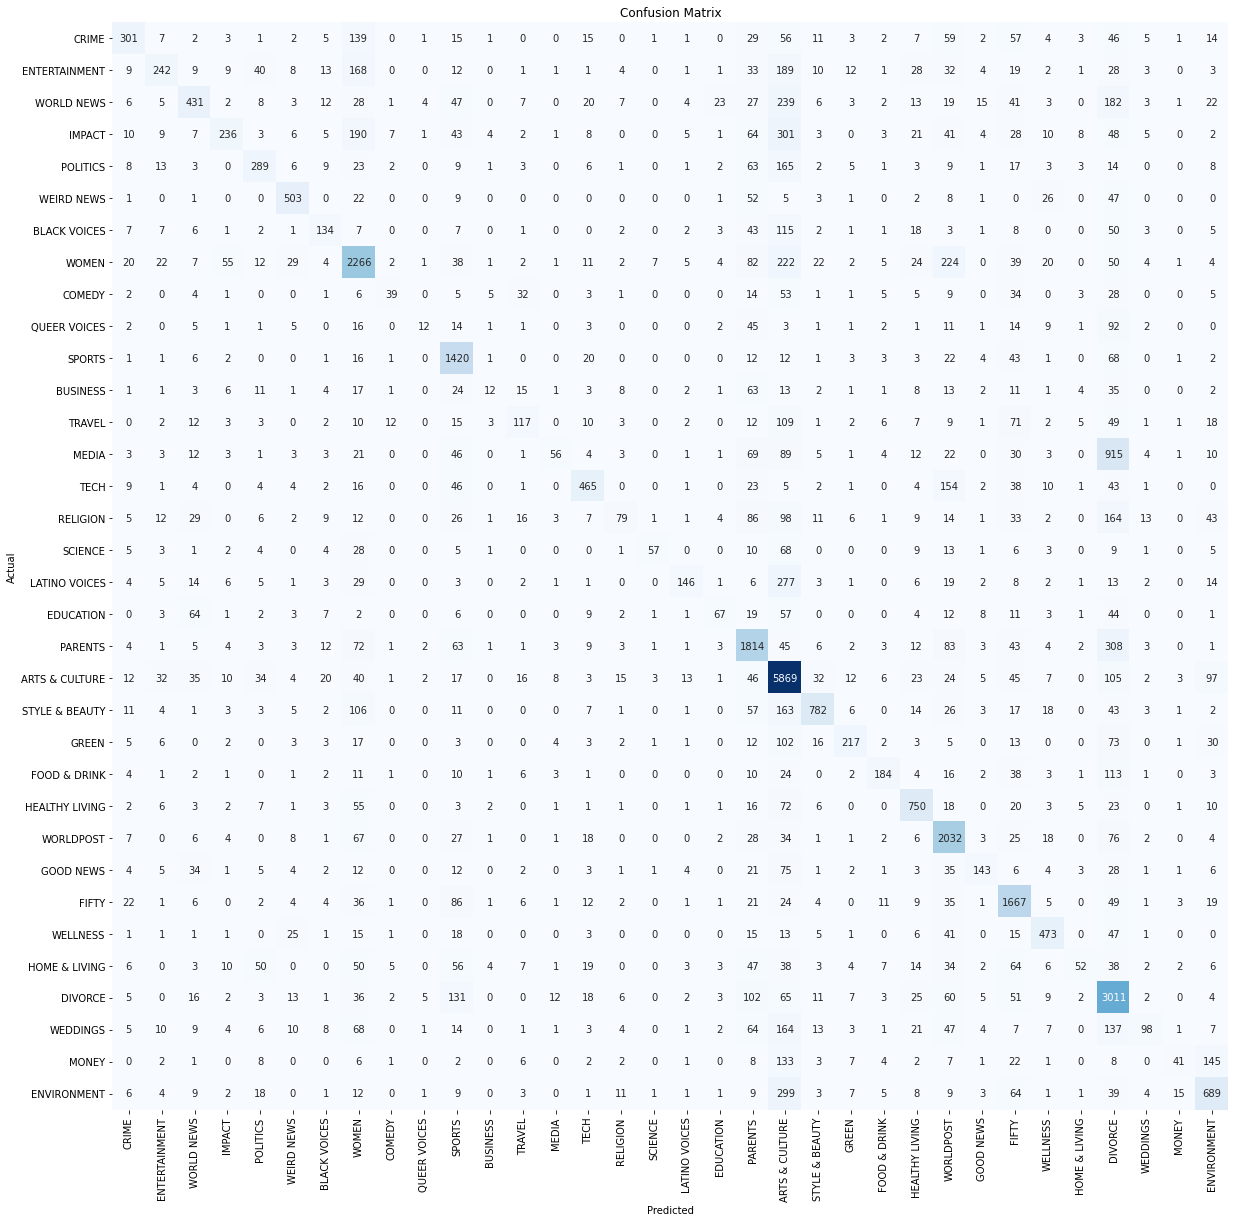

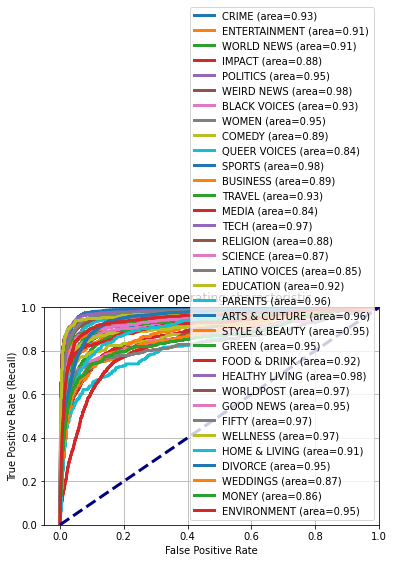

In [27]:
NB_classifier = ComplementNB()

accuracy, predictions, preds_prob = classifier_process(NB_classifier, x_train, y_train, x_test, y_test)

# Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Classifier Name:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy:  0.62752
Auc:  0.93805
F1 Score:  0.62084
Detail:
              precision    recall  f1-score   support

           0       0.53      0.48      0.50       793
           1       0.49      0.42      0.46       884
           2       0.49      0.44      0.46      1184
           3       0.51      0.43      0.46      1076
           4       0.55      0.53      0.54       670
           5       0.77      0.73      0.75       682
           6       0.48      0.43      0.46       430
           7       0.63      0.72      0.67      3188
           8       0.45      0.32      0.37       257
           9       0.26      0.17      0.20       246
    

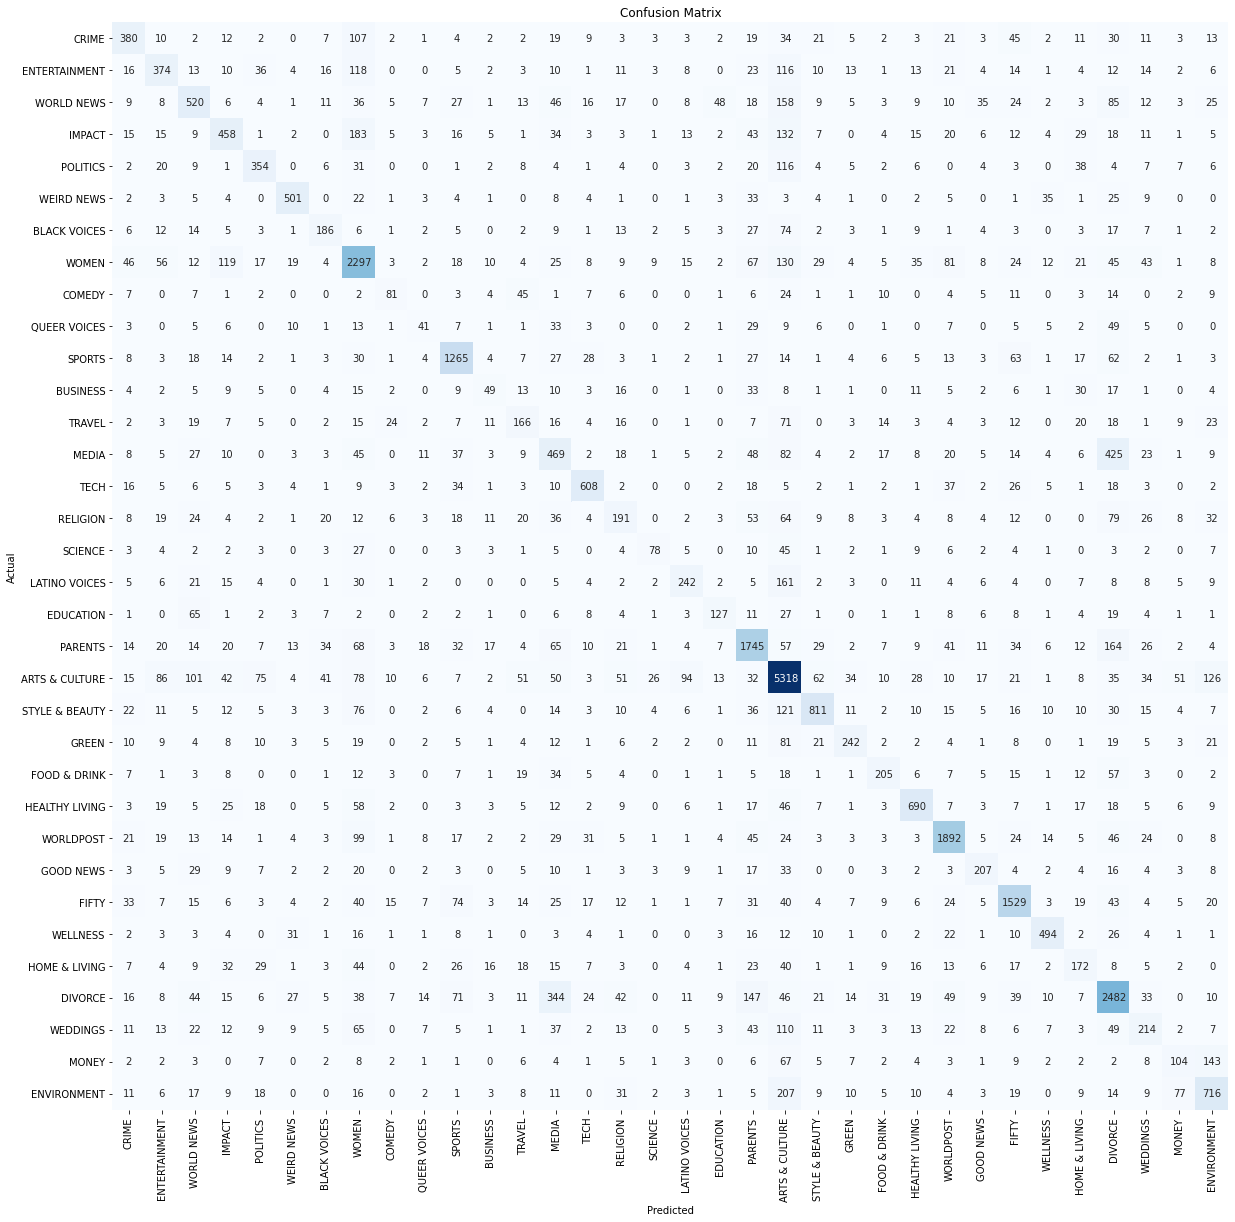

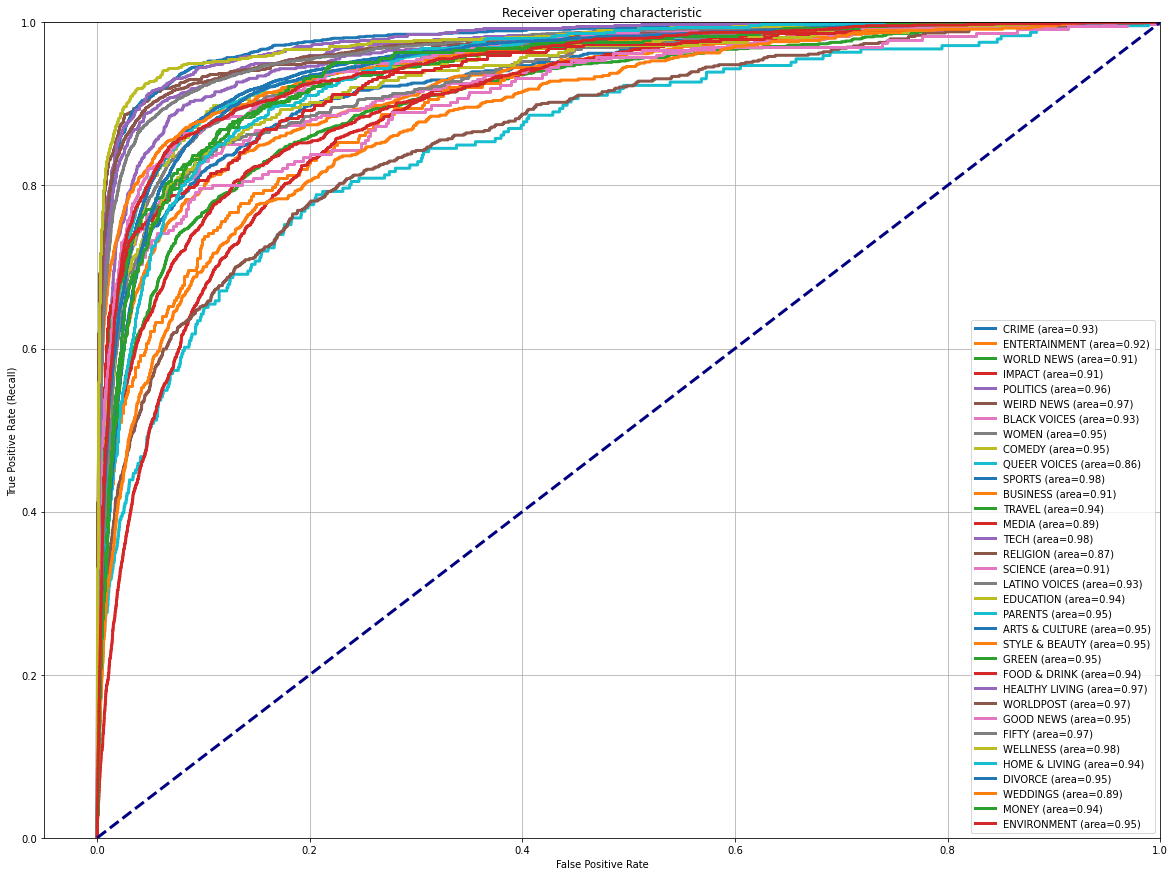

In [28]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(random_state=0)

accuracy, predictions, preds_prob = classifier_process(lr_classifier, x_train, y_train, x_test, y_test)

# SVM

In [29]:
from sklearn.svm import LinearSVC
svm_classifier = LinearSVC()

svm_classifier.fit(x_train, y_train)
# preds_prob = svm_classifier.predict_proba(x_test)

predictions = svm_classifier.predict(x_test)
accuracy = accuracy_score(predictions, y_test)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [30]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

svm_classifier = LinearSVC()
svm_clf = CalibratedClassifierCV(svm_classifier) 
svm_clf.fit(x_train, y_train)
predictions = svm_clf.predict(x_test)
accuracy = accuracy_score(predictions, y_test)
y_proba = svm_clf.predict_proba(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy:  0.60464
Auc:  0.92163
F1 Score:  0.57985
Detail:
              precision    recall  f1-score   support

           0       0.55      0.37      0.45       793
           1       0.51      0.32      0.40       884
           2       0.53      0.35      0.42      1184
           3       0.57      0.34      0.42      1076
           4       0.54      0.46      0.49       670
           5       0.80      0.71      0.75       682
           6       0.50      0.28      0.36       430
           7       0.56      0.73      0.64      3188
           8       0.49      0.21      0.30       257
           9       0.54      0.08      0.14       246
          10       0.69      0.77      0.73      1644
          11       0.34      0.10      0.16       267
          12       0.38      0.22      0.28       488
          13       0.34      0.17      0.23      1326
          14       0.71      0.70      0.71       837
          15       0.45      0.16      0.24       694
          16       0.

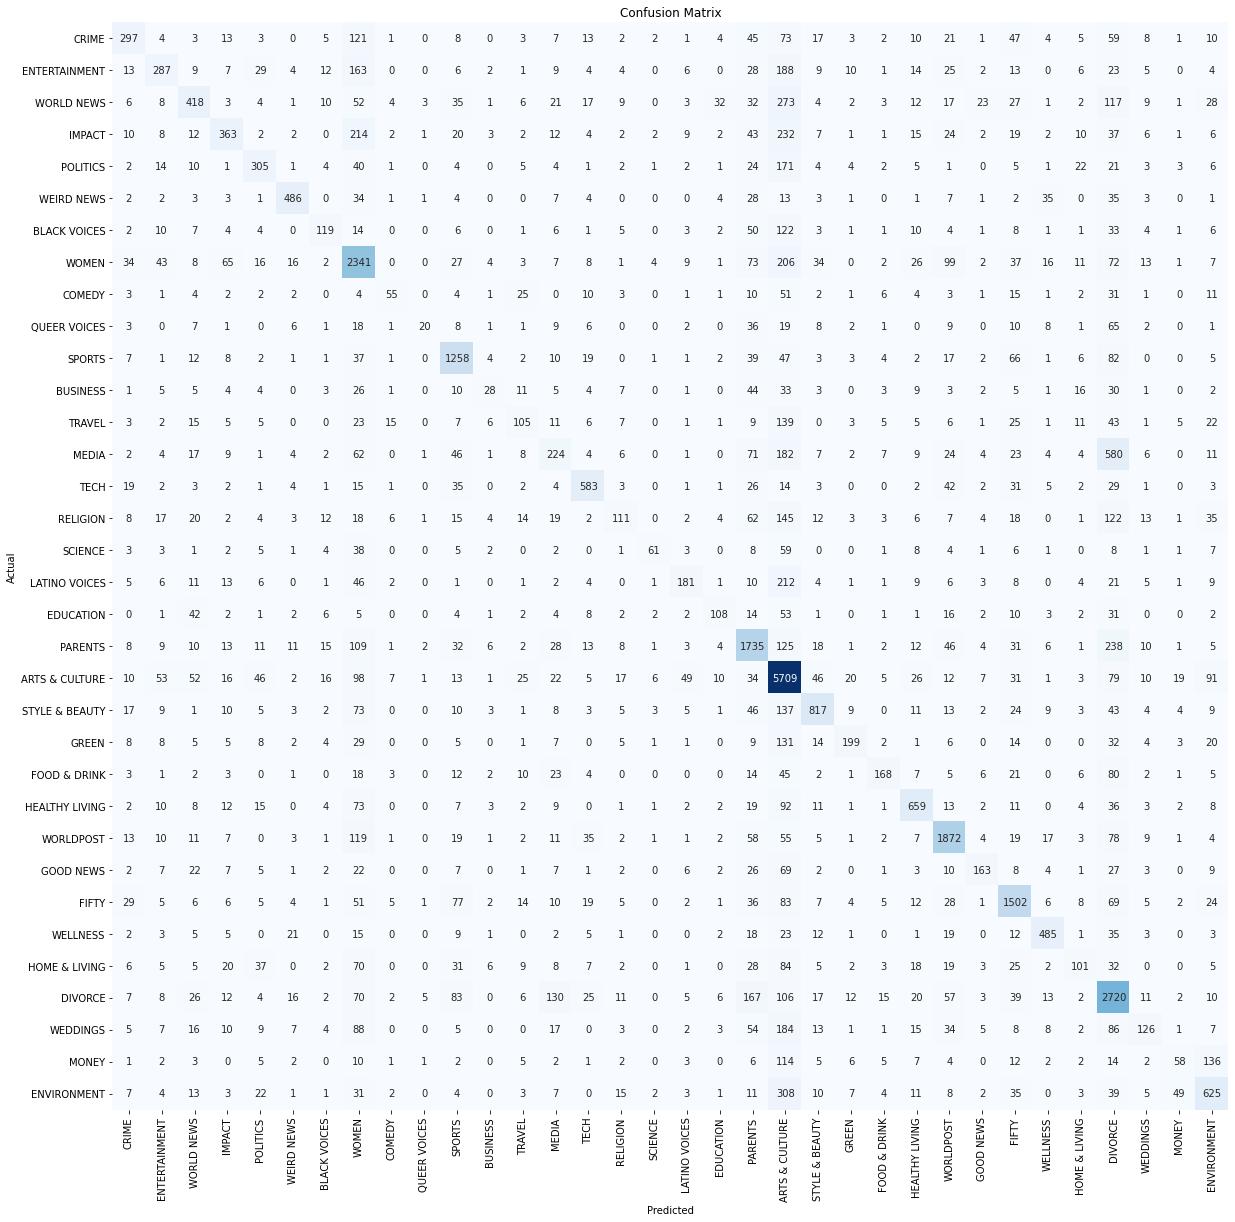

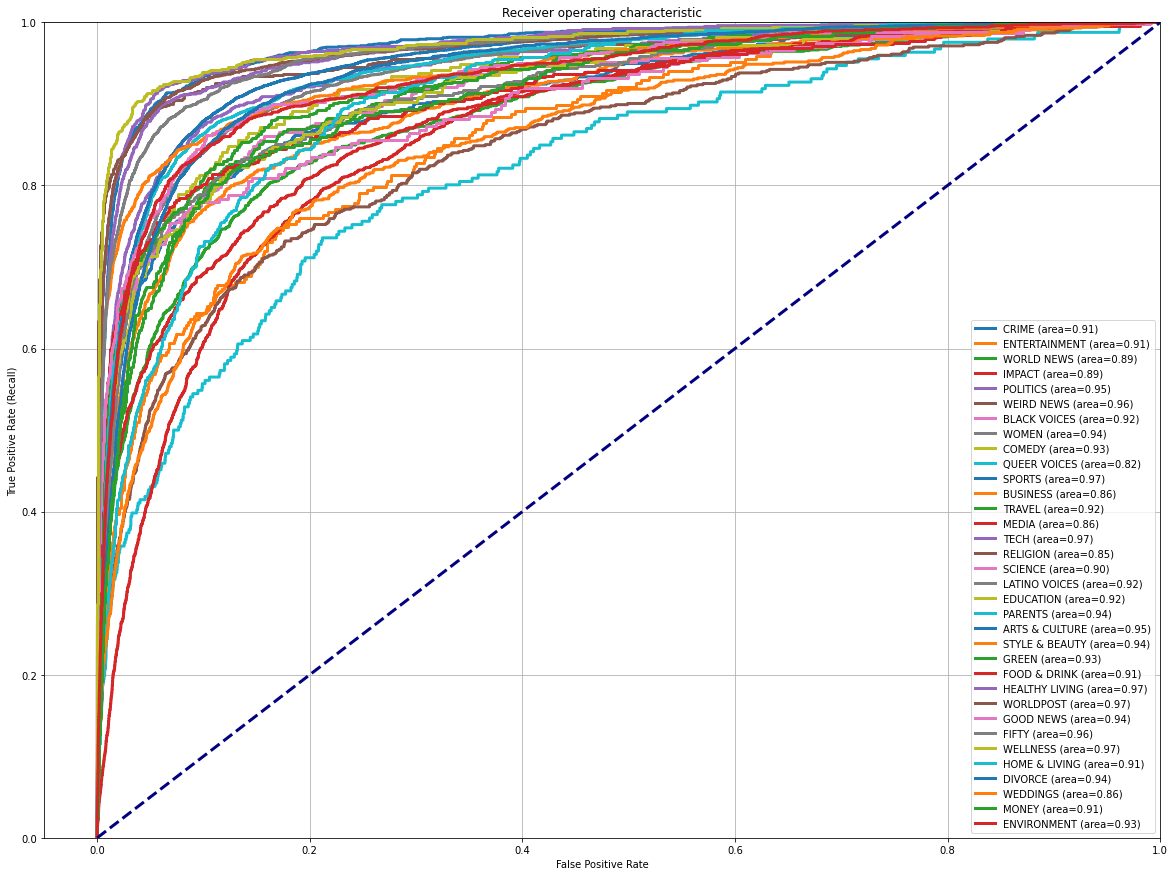

In [31]:
show_acc_pre_recall(y_test, predictions, y_proba)
plot_confusion_matrix(df, y_test, predictions)
plot_roc_auc (df, y_test, y_proba)

# Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

Classifier Name:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy:  0.16285
Auc:  0.76196
F1 Score:  0.04561
Detail:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       793
           1       0.00      0.00      0.00       884
           2       0.00      0.00      0.00      1184
           3       0.00      0.00      0.00      1076
           4       0.00      0.00      0.00       670
           5       0.00      0.00      0.00       682
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


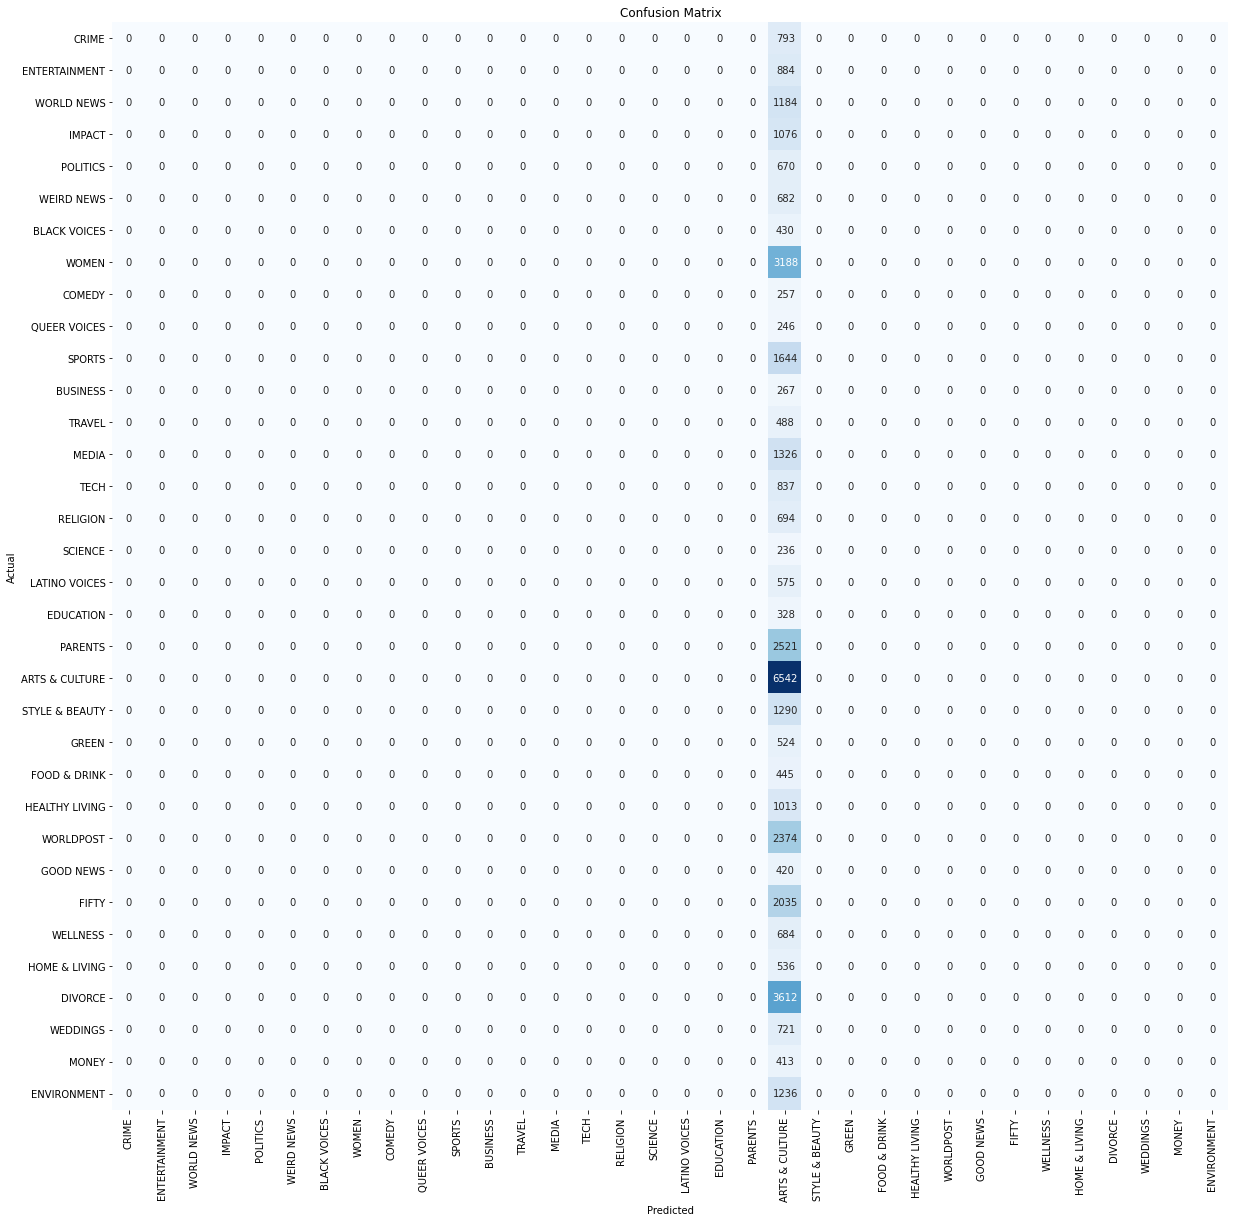

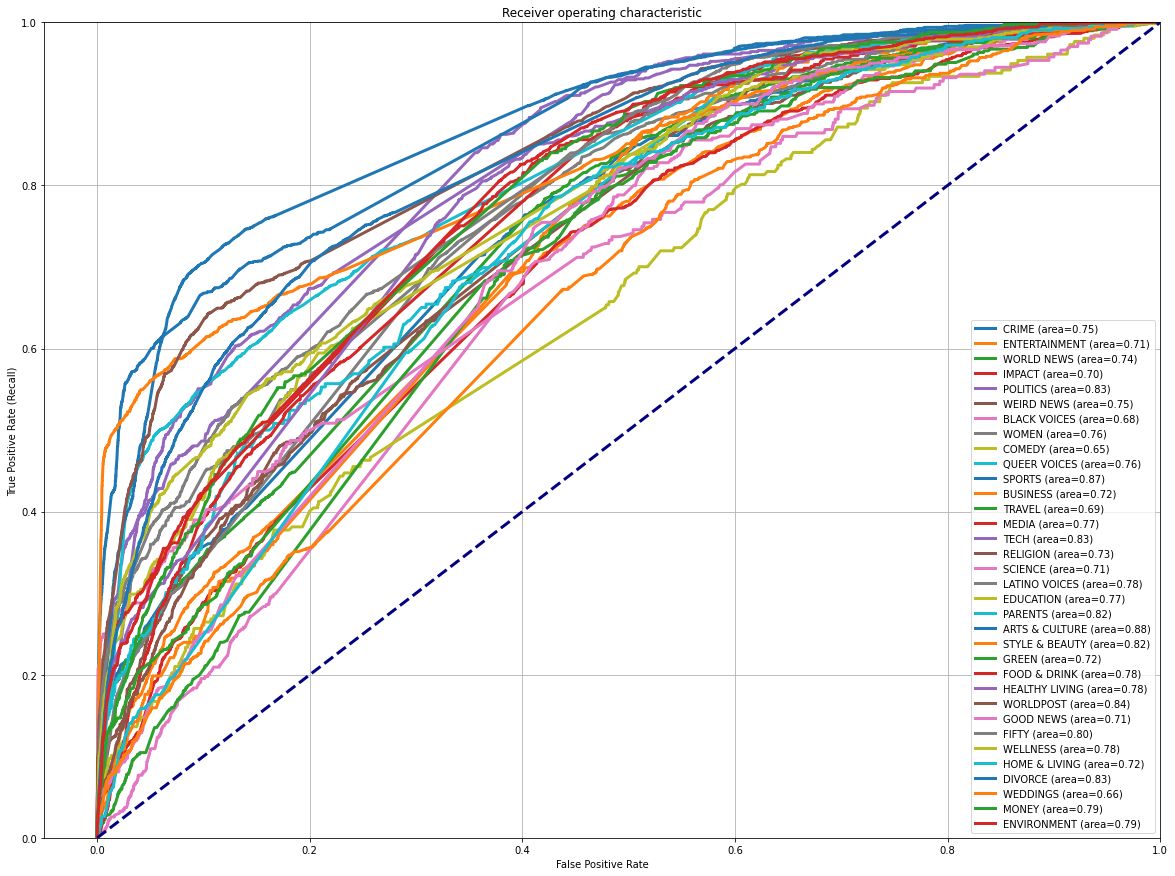

In [33]:
accuracy, predictions, preds_prob = classifier_process(rf_clf, x_train, y_train, x_test, y_test)